# EDA de encuesta de salarios SG

Este trabajo pretende descubrir grupos emergentes en las encuestas de salarios de SG entre los años 2022, 2021, 2020.

Estos grupos serán **por separado**, debido a que no podemos garantizar que las observaciones de 2 o los 3 años pertenecen al mismo individuo.

También aprovecharemos para introducir [Voilá](https://github.com/voila-dashboards/voila)!

Primero cargamos los datos:

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML, clear_output
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from yellowbrick.classifier import classification_report
import ipywidgets as widgets
import warnings
import plotly.express as px
import plotly.graph_objects as go

warnings.filterwarnings('ignore')


df_22 = pd.read_csv("answers-2022.csv", index_col=0)
df_21 = pd.read_csv("answers-2021.csv", index_col=0)
df_20 = pd.read_csv("answers-2020.csv", index_col=0)
# El salario de las personas de Mx se guarda en la columna salarymx y está en pesos.
# En la mayoría de los casos solo vamos a tomar en cuenta los datos de personas en Mx con salario en pesos.
df_22 = df_22[(df_22['country'] == 'México')]
df_21 = df_21[(df_21['country'] == 'México')]
df_20 = df_20[(df_20['country'] == 'México')]

NameError: name 'set_matplotlib_formats' is not defined

Y luego vemos si tenemos las mismas columnas en cada dataframe.

Esto es importante porque lo que queremos hacer es correr un modelo de clasificación no lineal, y para ello es importante, entre otras cosas:

1. tener las mismas columnas, o eliminar algunas para lograrlo.
2. tener aproximadamente la misma cantidad de observaciones.

In [ ]:
df_cols_22 = pd.DataFrame()
df_cols_21 = pd.DataFrame()
df_cols_20 = pd.DataFrame()
df_cols_22['columns_2022'] = df_22.columns
df_cols_21['columns_2021'] = df_21.columns
df_cols_20['columns_2020'] = df_20.columns
df_cols = pd.concat([df_cols_22, df_cols_21, df_cols_20], axis=1)
display(HTML(df_cols.to_html()))


,columns_2022,columns_2021,columns_2020
0,created,created,ip_address
1,salarymx,salarymx,created
2,salaryusd,salaryusd,recaptcha_score
3,extramx,extramx,salarymx
4,extrausd,extrausd,salaryusd
5,variation,variation,extramx
6,english_num,english_num,extrausd
7,english_label,english_label,variation
8,age,age,english_num
9,experience,experience,english_label


Vamos ahora a buscar los campos comunes entre los 3 datasets:

In [ ]:
common_cols = set(sorted(set(df_cols_22['columns_2022']) & set(df_cols_21['columns_2021']) & set(df_cols_20['columns_2020'])))
print(common_cols)

{'db_cosmos', 'act_test', 'city', 'cert_msexp', 'edutype', 'front_react', 'lang_python', 'db_neo4j', 'country', 'lang_perl', 'act_req', 'infra_vmware', 'dsc_h2o', 'cert_cgeit', 'ben_parking', 'dsc_tf', 'db_sqlserver', 'db_firebasert', 'ben_vouchers', 'lang_kotlin', 'act_ventas', 'cert_agile', 'db_mysql', 'lang_rust', 'lang_java', 'act_techwrite', 'cert_gcloudarch', 'lang_elixir', 'english_label', 'front_vue', 'db_oracle', 'infra_oshift', 'ben_lifeins', 'remote', 'cert_cisco', 'cert_awsdev', 'cert_infosec', 'variation', 'orgtype', 'act_dba', 'lang_cobol', 'act_erp', 'cert_testing1', 'extrausd', 'act_pm', 'db_dynamo', 'cert_awsarch', 'act_infosec', 'cert_oracle', 'cert_linux', 'profile', 'ben_gas', 'lang_swift', 'lang_groovy', 'dsc_watson', 'infra_chef', 'cert_scrum', 'cert_msass', 'cert_sap', 'cert_testing2', 'infra_puppet', 'act_prog', 'age', 'act_spi', 'dsc_knime', 'db_firestore', 'act_techsales', 'ben_cafeteria', 'cert_cobit', 'act_front', 'cert_java', 'ben_homeoffice', 'cert_sixsigm

Vamos ahora a eliminar las columnas que son colineales, como el `salarymx` y `salaryusd`, junto con `extramx` y `extrausd` , y columnas sin varianza, como `country`, dado que cerramos a México desde un inicio. También eliminaremos `variation` porque es un campo derivado. Finalmente, quitamos la columna `city` porque consideramos que durante la pandemia, la ciudad de residencia es irrelevante.

In [ ]:
common_cols.difference_update(['salaryusd','extramx','extrausd','country','variation','created','english_label','city'])
print(common_cols)  

{'db_cosmos', 'act_test', 'cert_msexp', 'edutype', 'front_react', 'lang_python', 'db_neo4j', 'lang_perl', 'act_req', 'infra_vmware', 'dsc_h2o', 'cert_cgeit', 'ben_parking', 'dsc_tf', 'db_sqlserver', 'db_firebasert', 'ben_vouchers', 'lang_kotlin', 'act_ventas', 'cert_agile', 'db_mysql', 'lang_rust', 'lang_java', 'act_techwrite', 'cert_gcloudarch', 'lang_elixir', 'front_vue', 'db_oracle', 'infra_oshift', 'ben_lifeins', 'remote', 'cert_cisco', 'cert_awsdev', 'cert_infosec', 'orgtype', 'act_dba', 'lang_cobol', 'act_erp', 'cert_testing1', 'act_pm', 'db_dynamo', 'cert_awsarch', 'act_infosec', 'cert_oracle', 'cert_linux', 'profile', 'ben_gas', 'lang_swift', 'lang_groovy', 'dsc_watson', 'infra_chef', 'cert_scrum', 'cert_msass', 'cert_sap', 'cert_testing2', 'infra_puppet', 'act_prog', 'age', 'act_spi', 'dsc_knime', 'db_firestore', 'act_techsales', 'ben_cafeteria', 'cert_cobit', 'act_front', 'cert_java', 'ben_homeoffice', 'cert_sixsigma', 'infra_k8s', 'db_elastic', 'cert_itilpra', 'dsc_domino', 

Y ahora vamos a subsetear los 3 dataframes con este conjunto de columnas comunes:

In [ ]:
list_common_cols = list(common_cols)
df_22_clean = df_22[list_common_cols]
df_21_clean = df_21[list_common_cols]
df_20_clean = df_20[list_common_cols]

Vamos ahora a ver histogramas de la columna objetivo `salarymx` para poder dividir en cuantiles en lugar de tener una columna contínua

(array([870., 908., 385., 146.,  38.,  24.,  12.,   7.,   1.,   4.]),
 array([  3000.,  27700.,  52400.,  77100., 101800., 126500., 151200.,
        175900., 200600., 225300., 250000.]),
 <BarContainer object of 10 artists>)

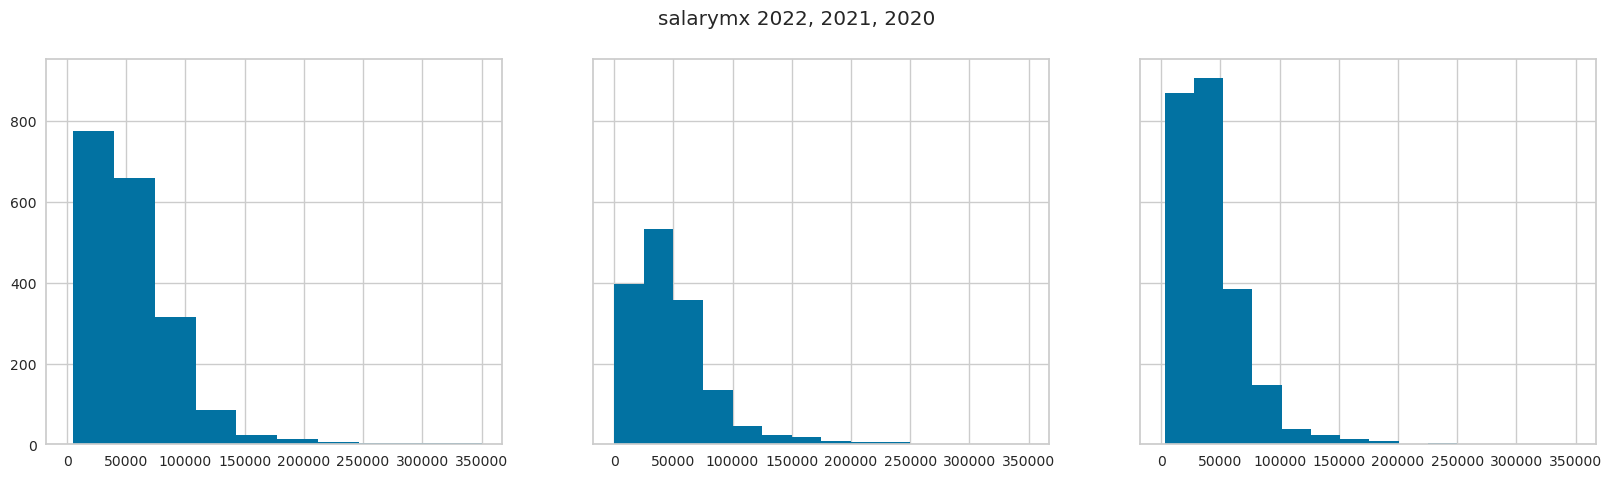

In [ ]:

fig = plt.figure()
fig.set_size_inches(20,5)
gs = fig.add_gridspec(1, 3, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
fig.suptitle('salarymx 2022, 2021, 2020')
axs[0].hist(df_22_clean['salarymx'])
axs[1].hist(df_21_clean['salarymx'])
axs[2].hist(df_20_clean['salarymx'])


Dividiremos por cuantiles de $10,000 MXN:

In [ ]:
bins = [0] + list(range(10000,500000,10000))
df_22_clean['salarymx_range'] = pd.cut(df_22_clean['salarymx'], bins=bins)
df_21_clean['salarymx_range'] = pd.cut(df_21_clean['salarymx'], bins=bins)
df_20_clean['salarymx_range'] = pd.cut(df_20_clean['salarymx'], bins=bins)

Finalmente vamos a limpiar algunas columnas que deben ser booleanas y eliminar `salarymx` ya que la discretizamos. Igual vamos a convertir a numéricas todas las columnas de respuesta **Sí/No** para que puedan ser admitidas en nuestros modelos.

In [ ]:
df_22_final = df_22_clean.drop(['salarymx'], axis=1)
df_21_final = df_21_clean.drop(['salarymx'], axis=1)
df_20_final = df_20_clean.drop(['salarymx'], axis=1)

bool_cols = ['act_arq', 'act_bi', 'act_cap', 'act_cons', 'act_dba', 'act_dir', 'act_doc', 'act_erp', 'act_front', 'act_infosec', 'act_pm', 'act_prog', 'act_req', 'act_soporte', 'act_spi', 'act_techsales', 'act_techwrite', 'act_test', 'act_uxd', 'act_ventas', 'ben_bonus', 'ben_cafeteria', 'ben_car', 'ben_cellphone', 'ben_edu', 'ben_equity', 'ben_family', 'ben_flexhours', 'ben_gas', 'ben_gym', 'ben_healthmajor', 'ben_healthminor', 'ben_homeoffice', 'ben_housing', 'ben_lifeins', 'ben_loan', 'ben_parking', 'ben_vouchers', 'cert_agile', 'cert_android', 'cert_awsarch', 'cert_awsdev', 'cert_ba', 'cert_cgeit', 'cert_cisco', 'cert_cobit', 'cert_entarch', 'cert_gcloudarch', 'cert_gdata', 'cert_gweb', 'cert_infosec', 'cert_itilint', 'cert_itilpra', 'cert_java', 'cert_linux', 'cert_msass', 'cert_msexp', 'cert_oracle', 'cert_pmp', 'cert_sap', 'cert_scrum', 'cert_sixsigma', 'cert_testing1', 'cert_testing2', 'db_DB2', 'db_cassandra', 'db_cosmos', 'db_dynamo', 'db_elastic', 'db_firebasert', 'db_firestore', 'db_mongoDB', 'db_mysql', 'db_neo4j', 'db_oracle', 'db_pgsql', 'db_redis', 'db_sap', 'db_sqlserver', 'dsc_alteryx', 'dsc_azureml', 'dsc_dataiku', 'dsc_domino', 'dsc_h2o', 'dsc_knime', 'dsc_rapidminer', 'dsc_sas', 'dsc_tf', 'dsc_watson', 'front_angular', 'front_react', 'front_vue', 'front_xamarin', 'infra_ansible', 'infra_chef', 'infra_docker', 'infra_k8s', 'infra_oshift', 'infra_ostack', 'infra_puppet', 'infra_terraform', 'infra_vmware', 'lang_bash', 'lang_clang', 'lang_cobol', 'lang_csharp', 'lang_delphi', 'lang_elixir', 'lang_go', 'lang_groovy', 'lang_java', 'lang_js', 'lang_kotlin', 'lang_perl', 'lang_php', 'lang_plsql', 'lang_python', 'lang_ruby', 'lang_rust', 'lang_scala', 'lang_swift', 'lang_vbnet', 'remote']
cat_cols = ['education','edutype','emptype','english_num', 'gender','orgtype','profile','remote','salarymx_range']
num_cols = ['experience','seniority']

d = {'Y': 1, 'N': 0, 'NaN': 0}

for column in bool_cols:
    df_22_final[column] = df_22_final[column].map(d)
    df_22_final[column] = df_22_final[column].astype('Int64')
    df_22_final[column] = df_22_final[column].fillna(0)
    df_21_final[column] = df_21_final[column].map(d)
    df_21_final[column] = df_21_final[column].astype('Int64')
    df_21_final[column] = df_21_final[column].fillna(0)
    df_20_final[column] = df_20_final[column].map(d)
    df_20_final[column] = df_20_final[column].astype('Int64')
    df_20_final[column] = df_20_final[column].fillna(0)

for column in cat_cols:
    df_22_final[column] = df_22_final[column].astype('category')
    df_21_final[column] = df_21_final[column].astype('category')
    df_20_final[column] = df_20_final[column].astype('category')

for column in num_cols:
    df_22_final[column] = df_22_final[column].astype('Int64')
    df_21_final[column] = df_21_final[column].astype('Int64')
    df_20_final[column] = df_20_final[column].astype('Int64')

df_dict = {'2022': df_22_final, '2021': df_21_final, '2020': df_20_final}

Finalmente, vamos a tratar de crear un modelo supervisado de RF, solo como primera aproximación a validar la hipótesis que la variable más crítica para acceder a sueldos altos es el inglés.

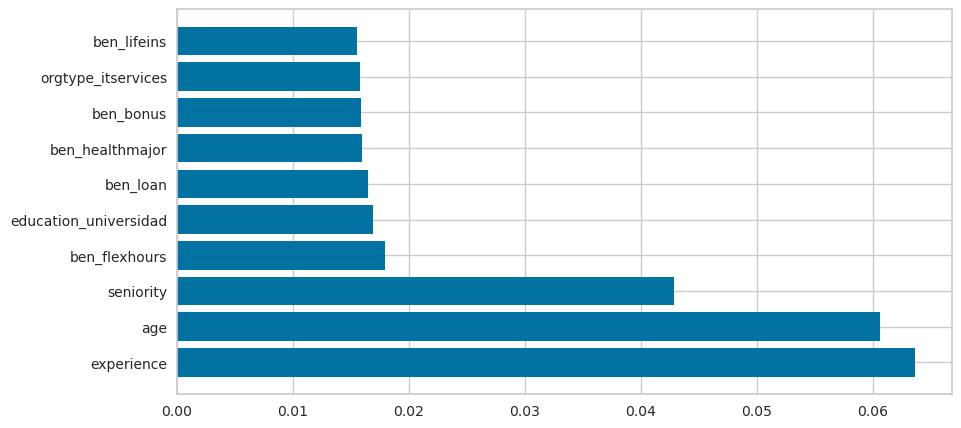

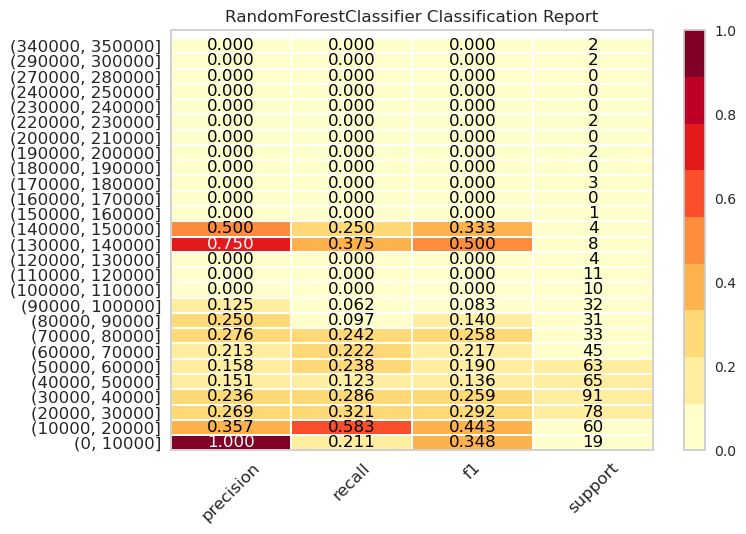

In [ ]:
predictors_raw = df_22_final.drop(['salarymx_range'], axis=1)
predictors = pd.get_dummies(predictors_raw)
dependant_raw = df_22_final['salarymx_range']
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(sorted(dependant_raw))
dependant = label_encoder.transform(dependant_raw)

predictors_train, predictors_test, dependant_train, dependant_test = train_test_split(predictors, dependant, test_size=.3)

rf = RandomForestClassifier(n_estimators=400)
rf.fit(predictors_train, dependant_train)
dependant_pred = rf.predict(predictors_test)

f = plt.figure()
f.set_figheight(5)
f.set_figwidth(10)
d = {'predictors_cols': predictors.columns, 'feature_imp': rf.feature_importances_}
df_imp = pd.DataFrame(d)
df_imp_sorted = df_imp.sort_values(by=['feature_imp'], ascending=False)
df_imp_top_10 = df_imp_sorted.head(10)
plt.barh(df_imp_top_10['predictors_cols'], df_imp_top_10['feature_imp'])
plt.show()
visualizer = classification_report(
    rf, predictors_train, dependant_train, predictors_test, dependant_test, classes=label_encoder.classes_, support=True
)

Ahora si vamos a crear nuestra app de Voilá:

In [ ]:
## Column 1

In [ ]:
def get_model(ano, rf_estimators):    
    df_final = df_dict[ano]
    predictors_raw = df_final.drop(['salarymx_range'], axis=1)
    predictors = pd.get_dummies(predictors_raw)
    dependant_raw = df_final['salarymx_range'].astype(str)
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(sorted(dependant_raw))
    dependant = label_encoder.transform(dependant_raw)

    predictors_train, predictors_test, dependant_train, dependant_test = train_test_split(predictors, dependant, test_size=.3)

    rf = RandomForestClassifier(n_estimators=rf_estimators)
    rf.fit(predictors_train, dependant_train)
    dependant_pred = rf.predict(predictors_test)
    return predictors_train, predictors_test, dependant_train, dependant_test, dependant_pred, rf.feature_importances_

### Column 1 - Row 1 + 2

In [2]:
ano_select = widgets.Select(
    options=['2022', '2021', '2020'],
    value='2022',
    description='Año:',
    disabled=False,
)

rf_est_slider = widgets.IntSlider(value=100, min=100, max=400, step=50)


widgets.HBox([ano_select, rf_est_slider])

In [ ]:
## Column 2

### Column 2 - Row 1

In [ ]:
out = widgets.Output()
out2 = widgets.Output()

In [ ]:
def display_classif_report(a):
    rf_estimators = rf_est_slider.value
    ano = ano_select.value
    with out2:
        out2.clear_output(wait=True)
        predictors_train, predictors_test, dependant_train, dependant_test, dependant_pred, importances = get_model(ano, rf_estimators)
        visualizer = classification_report(
            RandomForestClassifier(), predictors_train, dependant_train, predictors_test, dependant_test, classes=label_encoder.classes_, support=True
        )

def on_button_clicked(b):
    rf_estimators = rf_est_slider.value
    ano = ano_select.value
    with out:
        out.clear_output(wait=True)
        predictors_train, predictors_test, dependant_train, dependant_test, dependant_pred, importances = get_model(ano, rf_estimators)
        d = {'predictors_cols': predictors_train.columns, 'feature_imp': importances}
        df_imp = pd.DataFrame(d)
        df_imp_sorted = df_imp.sort_values(by=['feature_imp'], ascending=False)
        df_imp_top_10 = df_imp_sorted.head(10)
        #fig, ax = plt.subplots()
        fig = px.bar(x = df_imp_top_10['predictors_cols'], y = df_imp_top_10['feature_imp'])
        fig.update_layout(margin=go.layout.Margin(l=20, r=20, b=20, t=30), yaxis_title=None, xaxis_title=None)
        fig.show()
        #ax.barh(df_imp_top_10['predictors_cols'], df_imp_top_10['feature_imp'])
        #plt.show()

rf_est_slider.observe(on_button_clicked, names="value")
rf_est_slider.observe(display_classif_report, names="value")

ano_select.observe(on_button_clicked, names="value")
ano_select.observe(display_classif_report, names="value")

In [ ]:
on_button_clicked(None)
out

Output()

### Column 2 - Row 2

In [ ]:
display_classif_report(None)
out2